In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from key import HF_LLMA3_KEY, GROQ_KEY, REPLICATE_KEY
from groq import Groq       # https://console.groq.com/docs/models
import replicate
api = replicate.Client(api_token=REPLICATE_KEY)

In [2]:
movie_latest_small=pd.read_csv('../../data/processed_movie_latest_small.csv')
movie_latest_small.head()

,userId,movieId,title,genres,rating,timestamp,tag
0,1,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",4.0,964982703,NaN
1,1,3,Grumpier Old Men (1995),"Comedy, Romance",4.0,964981247,NaN
2,1,6,Heat (1995),"Action, Crime, Thriller",4.0,964982224,NaN
3,1,47,Seven (a.k.a. Se7en) (1995),"Mystery, Thriller",5.0,964983815,NaN
4,1,50,"Usual Suspects, The (1995)","Crime, Mystery, Thriller",5.0,964982931,NaN


In [3]:
processed_imbd_summary = pd.read_csv('../../data/processed_movie_imdb_summary.csv')
processed_imbd_summary.head()

,title,summary,summary_raw
0,Toy Story (1995),A little boy named Andy loves to be in his roo...,A little boy named Andy loves to be in his roo...
1,Grumpier Old Men (1995),Things don't seem to change much in Wabasha Co...,Things don't seem to change much in Wabasha Co...
2,Heat (1995),Neil and his professional criminal crew hunt t...,Hunters and their prey--Neil and his professio...
3,Seven (a.k.a. Se7en) (1995),Summary not found,Summary not found
4,"Usual Suspects, The (1995)","Following a truck hijack in New York, five cri...","Following a truck hijack in New York, five cri..."


In [4]:
# merge the two dataframes
movie_latest_small = movie_latest_small.merge(processed_imbd_summary, on='title', how='left')
movie_latest_small.head()

,userId,movieId,title,genres,rating,timestamp,tag,summary,summary_raw
0,1,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",4.0,964982703,NaN,A little boy named Andy loves to be in his roo...,A little boy named Andy loves to be in his roo...
1,1,3,Grumpier Old Men (1995),"Comedy, Romance",4.0,964981247,NaN,Things don't seem to change much in Wabasha Co...,Things don't seem to change much in Wabasha Co...
2,1,6,Heat (1995),"Action, Crime, Thriller",4.0,964982224,NaN,Neil and his professional criminal crew hunt t...,Hunters and their prey--Neil and his professio...
3,1,47,Seven (a.k.a. Se7en) (1995),"Mystery, Thriller",5.0,964983815,NaN,Summary not found,Summary not found
4,1,50,"Usual Suspects, The (1995)","Crime, Mystery, Thriller",5.0,964982931,NaN,"Following a truck hijack in New York, five cri...","Following a truck hijack in New York, five cri..."


In [5]:
# for each user, find his top-most rated movies
N_TOP_MOVIES = 10
def get_top_recent_movies(movies_df, user_id, num_movies=N_TOP_MOVIES):
    user_ratings = movies_df[movies_df['userId'] == user_id]
    user_ratings = user_ratings.sort_values(by=['rating', 'timestamp'], ascending=[False, False])
    return user_ratings.head(num_movies)

# get the top 5 movies for all users
top_movies = pd.DataFrame()
for user_id in movie_latest_small['userId'].unique():
    top_movies = pd.concat([top_movies, get_top_recent_movies(movie_latest_small, user_id, 10)])
top_movies.reset_index(drop=True, inplace=True)
top_movies.head(15)

,userId,movieId,title,genres,rating,timestamp,tag,summary,summary_raw
0,1,553,Tombstone (1993),"Action, Drama, Western",5.0,964984153,NaN,"After success cleaning up Dodge City, Wyatt Ea...","After success cleaning up Dodge City, Wyatt Ea..."
1,1,157,Canadian Bacon (1995),"Comedy, War",5.0,964984100,NaN,"The US economy is in a rut, and so is the pres...","The US economy is in a rut, and so is the pres..."
2,1,1298,Pink Floyd: The Wall (1982),"Drama, Musical",5.0,964984086,NaN,Pink Floyd has always tried to make meaningful...,Rock star Pink Floyd is a tortured soul. Becau...
3,1,3053,"Messenger: The Story of Joan of Arc, The (1999)","Drama, War",5.0,964984086,NaN,1429. While the war between France and England...,1429. While the war between France and England...
4,1,3448,"Good Morning, Vietnam (1987)","Comedy, Drama, War",5.0,964984054,NaN,A new Disc Jockey is shipped from Crete to Vie...,A new Disc Jockey is shipped from Crete to Vie...
5,1,151,Rob Roy (1995),"Action, Drama, Romance, War",5.0,964984041,NaN,"In the highlands of Scotland in the 1700s, Rob...","In the highlands of Scotland in the 1700s, Rob..."
6,1,1224,Henry V (1989),"Action, Drama, Romance, War",5.0,964984018,NaN,King Henry V of England (Sir Kenneth Branagh) ...,King Henry V of England (Sir Kenneth Branagh) ...
7,1,527,Schindler's List (1993),"Drama, War",5.0,964984002,NaN,Oskar Schindler is a vain and greedy German bu...,Oskar Schindler is a vain and greedy German bu...
8,1,5060,M*A*S*H (a.k.a. MASH) (1970),"Comedy, Drama, War",5.0,964984002,NaN,"""4077 MASH"" is about a Korean War-era MASH uni...",The personnel at the 4077 MASH unit deal with ...
9,1,3147,"Green Mile, The (1999)","Crime, Drama",5.0,964983873,NaN,Based on Stephen King's 1996 novel of the same...,Based on Stephen King's 1996 novel of the same...


In [6]:
# from transformers import pipeline
# summarizer = pipeline("summarization", model="facebook/bart-large-cnn")


In [7]:
import re

def extract_movie_titles(response):
    # Extract lines that match the format [Title (Year)]
    pattern = r"\[.*\]"
    titles = re.findall(pattern, response)
    return [title.strip("[]") for title in titles]

In [8]:
""" Number of users to run the recommender on
    (Use a small sample for faster results)
    If you want to run the recommender on all users, uncomment the last line
"""
# num_users = 5

# Uncomment below to run on all users
num_users = len(movie_latest_small['userId'].unique())
print(num_users)

610


In [9]:
def replicate_llma3(prompts, num_users, output_file='responses_basic.json'):
    responses = []
    for i in range(num_users):
        output = api.run(
            "meta/meta-llama-3-70b",
            input={
                "prompt": prompts[i],
                "temperature": 0,
            }
        )
        response = "".join(i for i in output)
        if i % 50 == 0:
            print(f"Completed {i} users")
        responses.append(response)
        # print(response)
    # parse the responses
    responses_recommendations = [extract_movie_titles(response) for response in responses]

    # # write the responses to a file
    # with open(output_file, 'w') as f:
    #     for i in range(num_users):
    #         f.write(str(responses_recommendations[i]) + '\n')
        
    #     print(f"Response written to {output_file}")
    return responses_recommendations


def llma3(prompts, num_users, output_file='responses_basic.json'):

    responses = []
    for i in range(num_users):
        response = client.chat.completions.create(
            model="llama3-70b-8192",
            messages= [
                {
                     'role':'user',
                     'content' : prompts[i]
                }
            ],
            temperature=0,
            # max_tokens=100,
            # stop=None
        )
    
        if i % 50 == 0:
            print(f"Completed {i} users")
        responses.append(response)

    # parse the responses
    responses_recommendations = [extract_movie_titles(response.choices[0].message.content) for response in responses]

    # write the responses to a file
    with open(output_file, 'w') as f:
        for i in range(num_users):
            f.write(str(responses_recommendations[i]) + '\n')
        
        print(f"Response written to {output_file}")
    return responses_recommendations


# calculate the hit rate
# hit rate for the recommendations
def hit_rate(recommendation, actual):
    hit = 0
    for rec in recommendation:
        if rec in actual:
            hit += 1
    return hit/len(recommendation)

# NDCG for the recommendations
def ndcg(recommendation, actual):
    dcg = 0
    for i, rec in enumerate(recommendation):
        if rec in actual:
            dcg += 1/np.log2(i+2)
    idcg = 0
    for i in range(len(actual)):
        idcg += 1/np.log2(i+2)
    return dcg/idcg


def eval_response(responses_recommendations, selected_movie_data, original_movie_data, num_users):
    hit_rates = []
    ndcg_scores = []
    for i in range(num_users):
        user_id = selected_movie_data['userId'].unique()[i]
        user_movies = original_movie_data[original_movie_data['userId']==user_id]
        user_watched_movies = user_movies['title'].values
        # print(f"User {user_id} watched movies: {user_watched_movies}")
        recommendation = responses_recommendations[i]
        # print(f"Recommendation: {recommendation}")
        hit_rate_ = hit_rate(recommendation, user_watched_movies)
        # print(f"Hit Rate: {hit_rate_}")
        hit_rates.append(hit_rate_)
        ndcg_ = ndcg(recommendation, user_watched_movies)
        # print(f"NDCG: {ndcg_}")
        ndcg_scores.append(ndcg_)

    avg_hit_rate = np.mean(hit_rates)
    avg_ndcg = np.mean(ndcg_scores)

    print(f"Average Hit Rate: {avg_hit_rate}")
    print(f"Average NDCG: {avg_ndcg}")

    return hit_rates, ndcg_scores


In [10]:
# read the responses from the json file
def read_responses(output_file):
    responses_recommendations = []
    with open(output_file, 'r') as f:
        for line in f:
            responses_recommendations.append(eval(line))
    return responses_recommendations

In [11]:
def generate_prompt_from_df(df, user_id, num):
    df_user = df[df['userId'] == user_id]
    movies_list = '\n'.join([f"Movie {i+1}: {row['title']}; Genre: {row['genres']}; Rating: {row['rating']}; Plot: {row['summary']}" for i, row in df_user.iterrows()])
    
    prompt_template = '''
I am user {user_id}. My most recent {num} top-rated movies are listed below along with their genres, my ratings and a brief plot summary.:
{movies_list}
Please recommend 10 movies similar to these that I haven't watched yet. Format your response as a list of movie titles, using brackets around the titles and separating each title with a new line for easy parsing.
Example format:
Here are the 10 movies recommended for you: 
[Midnight Cowboy (1969)]
[Lost in Translation (2003)]
[etc.]

Answer:
    '''

    prompt = prompt_template.format(user_id=user_id, num=num, movies_list=movies_list)
    return prompt

In [12]:
prompts_plot = []
for user_id in top_movies['userId'].unique():
    prompt_plot = generate_prompt_from_df(top_movies, user_id, N_TOP_MOVIES)
    prompts_plot.append(prompt_plot)

print(prompts_plot[0])


I am user 1. My most recent 10 top-rated movies are listed below along with their genres, my ratings and a brief plot summary.:
Movie 1: Tombstone (1993); Genre: Action, Drama, Western; Rating: 5.0; Plot: After success cleaning up Dodge City, Wyatt Earp moves to Tombstone, Arizona, and wishes to get rich in obscurity. He meets his brothers there, as well as his old friend Doc Holliday. A band of outlaws that call themselves The Cowboys are causing problems in the region with various acts of random violence, and inevitably come into confrontation with Holliday and the Earps, which leads to a shoot-out at the O.K. Corral.
Movie 2: Canadian Bacon (1995); Genre: Comedy, War; Rating: 5.0; Plot: The US economy is in a rut, and so is the president's approval rating. What we need is a good war, but the Russians aren't interested. Hey -- how about that big polite country to the north? Niagara Falls Sheriff Bud B. Boomer takes this all a bit too seriously, though.
Movie 3: Pink Floyd: The Wall 

In [13]:
prompt_summary_rec = replicate_llma3(prompts_plot, num_users, output_file=f'responses_add_summary_1.json')

hit_rates_summary, ndcg_scores_summary = eval_response(prompt_summary_rec, top_movies, movie_latest_small, num_users)
    

Completed 0 users
Completed 50 users
Completed 100 users
Completed 150 users
Completed 200 users
Completed 250 users
Completed 300 users
Completed 350 users
Completed 400 users
Completed 450 users
Completed 500 users
Completed 550 users
Completed 600 users
Average Hit Rate: 0.0773971995473198
Average NDCG: 0.014445080387506788


50min 0.85usd 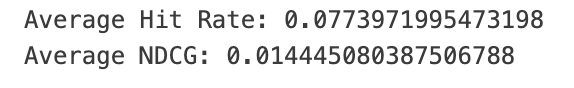